## Mount Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Use NVIDIA Tesla T4 GPU in Colab

In [17]:
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True Tesla T4
Using device: cuda


## Import libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import io
import base64
from PIL import Image
import joblib

## Load CSVs
base64 is a slightly modified idimage.csv where I replaced the name attribute with id and made sure every example has corresponding metadata in metadata.csv

In [7]:
base64_df = pd.read_csv('/content/drive/MyDrive/colab/598/base64.csv')
metadata_df = pd.read_csv('/content/drive/MyDrive/colab/598/metadata.csv')

In [14]:
metadata_df.info()
base64_df.info()
base64_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_fraud            998 non-null    bool   
 1   fraudpattern        998 non-null    float64
 2   gender_encoded      998 non-null    int64  
 3   ethnicity_encoded   998 non-null    int64  
 4   class_encoded       998 non-null    int64  
 5   hair_color_encoded  998 non-null    int64  
 6   eye_color_encoded   998 non-null    int64  
 7   is_donor            998 non-null    int64  
 8   is_veteran          998 non-null    int64  
 9   age                 998 non-null    float64
 10  license_validity    998 non-null    float64
 11  height_numeric      998 non-null    float64
 12  weight_numeric      998 non-null    float64
 13  id                  998 non-null    object 
dtypes: bool(1), float64(5), int64(7), object(1)
memory usage: 102.5+ KB
<class 'pandas.core.frame.DataFrame'>


,id,imageData
0,generated.photos_v3_0081593,iVBORw0KGgoAAAANSUhEUgAAAlgAAAF3CAIAAAD2FqL1AA...
1,generated_fake_2_66,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,generated_fake_2_72,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,generated.photos_v3_0054386,iVBORw0KGgoAAAANSUhEUgAAAlgAAAF3CAIAAAD2FqL1AA...
4,generated.photos_v3_0011839_fake_5540,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


## Process metadata and images for training

The 'is_fraud' attribute is our ground truth and 'id' is for query purposes. We will drop those from the features.

The metadata features need to be standardized to ensure equal contribution to learning. We will be using StandardScaler for that

In [19]:
X_metadata = metadata_df.drop(['is_fraud', 'id'], axis=1)
y_metadata = metadata_df['is_fraud']

scaler = StandardScaler()
X_metadata_scaled = scaler.fit_transform(X_metadata)
X_metadata_scaled

array([[-1.09831254,  2.11044414, -1.7648613 , ..., -2.99666404,
        -2.76164635, -2.42061644],
       [-1.09831254,  2.11044414, -1.7648613 , ..., -2.99666404,
        -2.76164635, -2.42061644],
       [-2.66419242, -0.90275078, -1.01790134, ...,  0.33330214,
         0.83863734,  0.34564014],
       ...,
       [ 0.46756734, -0.90275078, -1.01790134, ...,  0.33512578,
        -0.05084451,  0.27898336],
       [ 0.46756734,  0.60384668,  0.47601857, ...,  0.33330214,
         0.1185806 ,  0.96221541],
       [ 0.46756734,  0.60384668,  0.47601857, ...,  0.33330214,
         0.20329316, -0.55422646]])

We decode each base64 image and resize them using EfficientNet pretrained weights transforms and keep them in a list. PIL is useful for these file format usecases. Also we add a batch dimension with unsqueeze() so we have 4D tensors.

In [46]:
def base64_to_tensor(base64_str):
    image_bytes = base64.b64decode(base64_str)
    image = Image.open(io.BytesIO(image_bytes))
    transform = models.EfficientNet_B3_Weights.DEFAULT.transforms()
    return transform(image).unsqueeze(0)

images = []
for img_id in metadata_df['id']:
    base64_str = base64_df.loc[base64_df['id'] == img_id, 'imageData'].values[0]
    images.append(base64_to_tensor(base64_str))

len(images)

998

Split data into train and validation sets.
We keep 20% of the full dataset for the test set.

In [47]:
X_train, X_val, y_train, y_val, img_train, img_val = train_test_split(
    X_metadata_scaled, y_metadata, images, test_size=0.2, random_state=42
)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

img_train_tensor = torch.cat(img_train, dim=0).to(device)
img_val_tensor = torch.cat(img_val, dim=0).to(device)

## Model training



We will use this FraudDataset to serve each sample during training using DataLoader for batching. Also we shuffle the data for better generalization.

In [49]:
class FraudDataset(Dataset):
    def __init__(self, metadata, images, labels):
        self.metadata = torch.tensor(metadata, dtype=torch.float32)
        self.images = images # img tensors btw
        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.metadata[idx], self.images[idx], self.labels[idx]

train_dataset = FraudDataset(X_train, img_train_tensor, y_train)
val_dataset = FraudDataset(X_val, img_val_tensor, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In this model we process 2 data streams in parallel: one for imagesand one for metadata and then combine them for final fraud prediction.  It uses a pre-trained EfficientNet-B3 as an image feature extractor to process ID photo data.

In parallel, a simple fully connected subnetwork processes metadata.

These two are then concatenated and passed through a classification head that predicts the likelihood of fraud using a sigmoid activation.

In [50]:
class CNNModel(nn.Module):
    def __init__(self, metadata_dim, dropout=0.5):
        super().__init__()
        # EfficientNet backbone
        self.image_backbone = models.efficientnet_b3(weights='DEFAULT')

        # get no of features from backbone
        num_backbone_features = self.image_backbone.classifier[1].in_features
        # replace the original classifier to get raw features
        self.image_backbone.classifier = nn.Identity()

        # metadata processing
        self.metadata_subnet = nn.Sequential(
            nn.Linear(metadata_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # classificateion head
        self.classifier = nn.Sequential(
            nn.Linear(num_backbone_features + 128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, metadata, image):
        image_features = self.image_backbone(image) # batch_size, x no_backbone_features
        metadata_features = self.metadata_subnet(metadata) # batch_size x 128
        combined = torch.cat([image_features, metadata_features], dim=1) # concatenate both streams
        return self.classifier(combined) # do classification

Set the epochs to 50 as we didn't notice improvements in the scores beyond that. We will be using binary cross-entropy loss BCE for the loss function as the target is binary i.e. fraud vs non-fraud.

In [51]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):


    for epoch in range(epochs):
      #train
        model.train()
        epoch_train_losses, epoch_train_accs = [], []

        for metadata, images, labels in train_loader:
            metadata, images, labels = metadata.to(device), images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(metadata, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())
            epoch_train_accs.append(((outputs > 0.5) == labels).float().mean().item())

        train_losses.append(np.mean(epoch_train_losses))
        train_accs.append(np.mean(epoch_train_accs))

        # validation
        model.eval()
        with torch.no_grad():
            epoch_val_losses, epoch_val_accs = [], []
            for metadata, images, labels in val_loader:
                metadata, images, labels = metadata.to(device), images.to(device), labels.to(device)
                outputs = model(metadata, images)
                val_loss = criterion(outputs, labels)
                epoch_val_losses.append(val_loss.item())
                epoch_val_accs.append(((outputs > 0.5) == labels).float().mean().item())

            val_losses.append(np.mean(epoch_val_losses))
            val_accs.append(np.mean(epoch_val_accs))

        print(f"Epoch {epoch+1}: Train Loss {np.mean(epoch_train_losses):.4f}, Acc {np.mean(epoch_train_accs):.4f}          Val Loss {np.mean(epoch_val_losses):.4f}, Acc {np.mean(epoch_val_accs):.4f}")


model = CNNModel(metadata_dim=X_metadata_scaled.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)


Epoch 1: Train Loss 0.1250, Acc 0.9675          Val Loss 2.5984, Acc 0.1696
Epoch 2: Train Loss 0.0266, Acc 1.0000          Val Loss 0.0135, Acc 1.0000
Epoch 3: Train Loss 0.0115, Acc 1.0000          Val Loss 0.0049, Acc 1.0000
Epoch 4: Train Loss 0.0088, Acc 1.0000          Val Loss 0.0053, Acc 1.0000
Epoch 5: Train Loss 0.0069, Acc 1.0000          Val Loss 0.0031, Acc 1.0000
Epoch 6: Train Loss 0.0052, Acc 1.0000          Val Loss 0.0019, Acc 1.0000
Epoch 7: Train Loss 0.0024, Acc 1.0000          Val Loss 0.0018, Acc 1.0000
Epoch 8: Train Loss 0.0045, Acc 1.0000          Val Loss 0.0015, Acc 1.0000
Epoch 9: Train Loss 0.0018, Acc 1.0000          Val Loss 0.0014, Acc 1.0000
Epoch 10: Train Loss 0.0029, Acc 1.0000          Val Loss 0.0006, Acc 1.0000
Epoch 11: Train Loss 0.0018, Acc 1.0000          Val Loss 0.0006, Acc 1.0000
Epoch 12: Train Loss 0.0009, Acc 1.0000          Val Loss 0.0006, Acc 1.0000
Epoch 13: Train Loss 0.0010, Acc 1.0000          Val Loss 0.0005, Acc 1.0000
Epoch 14

Save our model weights and scaler for inference in PostgreSQL later!

Now onto plotting the loss curve

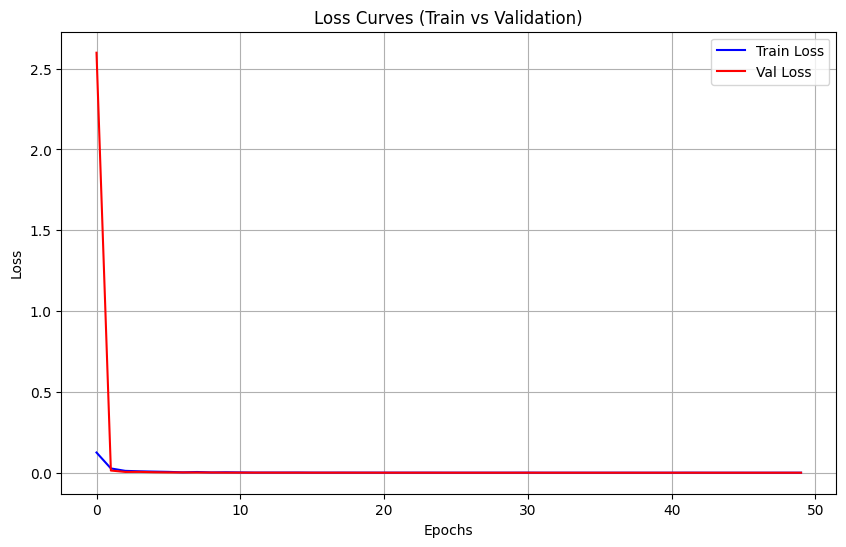

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(50), train_losses, label='Train Loss', color='blue')
plt.plot(range(50), val_losses, label='Val Loss', color='red')
plt.title('Loss Curves (Train vs Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Save our model for inference later

In [43]:
torch.save({
    'model_state_dict': model.state_dict(),
    'input_metadata_size': model.metadata_subnet[0].in_features
}, '/content/drive/MyDrive/colab/598/model_weights.pt')


import pickle
with open('/content/drive/MyDrive/colab/598/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)